In [0]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


def to_img(x, h, w):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, h, w)
    return x


num_epochs = 2
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# # ls drive/My\ Drive
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)

In [0]:
# cp MNIST drive/My\ Drive/MNIST -rf
ls drive/My\ Drive/MNIST

MNIST/


In [0]:
dataset = MNIST('./drive/My Drive/MNIST', train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [0]:
dd = next(iter(dataloader))
img, _  = dd
print(img.shape)


c = img.view([img.shape[0], -1])
c.shape
# a = torch.arange(1, 17)
# b = a.reshape([4,4])
# b.shape
# b.view()

torch.Size([128, 1, 28, 28])


torch.Size([128, 784])

In [0]:
del dd

In [0]:
dataloader.__dict__

{'_DataLoader__initialized': True,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7f74cab65ac8>,
 'batch_size': 128,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate>,
 'dataset': Dataset MNIST
     Number of datapoints: 60000
     Root location: ./drive/My Drive/MNIST
     Split: Train,
 'drop_last': False,
 'num_workers': 0,
 'pin_memory': False,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7f74cab65a90>,
 'timeout': 0,
 'worker_init_fn': None}

In [0]:
# for data in dataloader:
#   img, _ = data
#   print(img.shape)

In [4]:

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 9))
        self.decoder = nn.Sequential(
            nn.Linear(9, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z

    def generate(self, code):
#         z = self.encoder(x)
        x = self.decoder(code)
        return x
      

model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
#         import pdb; pdb.set_trace()      
        img,_ = data

        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        output, _ = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data, 28, 28)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder.pth')
# torch.save(model.state_dict(), './drive/My Drive/AutoEncoderProject/sim_autoencoder.pth')


epoch [1/2], loss:0.0549
epoch [2/2], loss:0.0406


In [0]:
# torch.__version__

In [0]:
# class autoencoder(nn.Module):
#     def __init__(self):
#         super(autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(28 * 28, 128),
#             nn.ReLU(True),
#             nn.Linear(128, 200))
#         self.decoder = nn.Sequential(
#             nn.Linear(200, 28 * 28), 
#             nn.Tanh())

#     def forward(self, x):
#         z = self.encoder(x)
#         x = self.decoder(z)
#         return x, z

#     def generate(self, code):
# #         z = self.encoder(x)
#         x = self.decoder(code)
#         return x



class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1),  # b, 16, 5, 5
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z

    def generate(self, code):
#         z = self.encoder(x)
        x = self.decoder(code)
        return x
      
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

      

# model = autoencoder().cuda()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     model.parameters(), lr=learning_rate, weight_decay=1e-5)

num_epochs= 10
for epoch in range(num_epochs):
    for data in dataloader:
#         import pdb; pdb.set_trace()      
        img,_ = data

#         img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        output, _ = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data, 28, 28)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder.pth')
# torch.save(model.state_dict(), './drive/My Drive/AutoEncoderProject/sim_autoencoder.pth')


epoch [1/10], loss:0.0151
epoch [2/10], loss:0.0054
epoch [3/10], loss:0.0036
epoch [4/10], loss:0.0027
epoch [5/10], loss:0.0022
epoch [6/10], loss:0.0019
epoch [7/10], loss:0.0016
epoch [8/10], loss:0.0014
epoch [9/10], loss:0.0012
epoch [10/10], loss:0.0011


In [0]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
   ConvTranspose2d-3            [-1, 1, 28, 28]             145
              Tanh-4            [-1, 1, 28, 28]               0
Total params: 305
Trainable params: 305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.00
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [0]:
# loss.data
output, du = model(img)
du.shape


torch.Size([1000, 16, 28, 28])

In [0]:
# loss.data[0]
# model.decoder()
output.shape


torch.Size([1000, 1, 28, 28])

In [0]:
ls

data/  drive/  mlp_img/  sample_data/  sim_autoencoder.pth


In [0]:
ls mlp_img/*

mlp_img/image_0.png


In [0]:
from matplotlib import pyplot as plt


In [0]:

a = plt.imread('./mlp_img/image_9.png')
plt.imshow(a)

FileNotFoundError: ignored

In [0]:
# test the model
# output = model(img)
img.shape
c.shape
img.shape
output.shape
c.shape

In [0]:

for i in range(10):
  plt.figure()
  c = img[i].cpu().detach()
  c = c.reshape([28,28])
  plt.imshow(c.numpy())
  
  
  plt.figure()
  output, code = model(img[i])
  a = output.reshape([28,28])
  a = a.cpu().detach()
  plt.imshow(a.numpy())
  
  
  plt.figure()
  c = code.cpu().detach()
  c = c.reshape([3,3])
  plt.imshow(c.numpy())
  

In [0]:
output, code = model(img[i])

In [0]:
code

In [8]:
latent_d = 3
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_d)
        self.fc22 = nn.Linear(400, latent_d)
        self.fc3 = nn.Linear(latent_d, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if torch.cuda.is_available():
    model.cuda()

reconstruction_function = nn.MSELoss(size_average=False)


def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD


optimizer = torch.optim.Adam(
  model.parameters(), lr=1e-3, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.data#[0]
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(img),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                loss.data / len(img)))
                
#                 loss.data[0] / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))
    if epoch % 10 == 0:
        save = to_img(recon_batch.cpu().data, 28, 28)
#         save_image(save, './vae_img/image_{}.png'.format(epoch))

# torch.save(model.state_dict(), './vae.pth')
# torch.save(model.state_dict(), './drive/My Drive/AutoEncoderProject/vae.pth')


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


TypeError: ignored

In [0]:
mu.shape

In [9]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
    
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x_1 = F.relu(self.conv1(x))
        x = F.max_pool2d(x_1, 2, 2)
        x_2 = F.relu(self.conv2(x))
        x = F.max_pool2d(x_2, 2, 2)
        x = x.view(-1, 4*4*50)
        x_3 = F.relu(self.fc1(x))
        h = F.softmax(self.fc2(x_3), dim=1)
        return h, x_3, x_2, x_1      
        
#         x = self.fc2(x_3)
#         return F.softmax(x, dim=1)
      
#     def forward(self, x):
#         x_1 = F.relu(self.conv1(x))
#         x = F.max_pool2d(x_1, 2, 2)
#         x_2 = F.relu(self.conv2(x))
#         x = F.max_pool2d(x_2, 2, 2)
#         x = x.view(-1, 4*4*50)
#         x_3 = F.relu(self.fc1(x))
# #         x = self.fc2(x)
# #         return F.softmax(x, dim=1)
#         h = F.sigmoid(self.fc2(x_3))
#         return h, x_3, x_2, x_1      
      
    
model_n = Model()
if cuda:
    model_n.cuda() # CUDA!
optimizer = optim.Adam(model_n.parameters(), lr=1e-3)      


Populating the interactive namespace from numpy and matplotlib


In [10]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

0it [00:00, ?it/s]

9920512it [00:01, 9004825.81it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 136087.33it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2586583.39it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51554.89it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
# del dataset
# del train, test
# del data, target
del  evaluate_x,  evaluate_y

NameError: ignored

In [11]:
EPOCHS = 15
losses = []

model_n.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred, _, _, _ = model_n(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model_n.eval()
    output, _, _, _ = model_n(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Train Epoch: 1/15 [60000/60000 (100%)]	Loss: 1.508591	 Test Accuracy: 94.3600%


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


 Train Epoch: 2/15 [60000/60000 (100%)]	Loss: 1.490447	 Test Accuracy: 97.6900%
 Train Epoch: 3/15 [60000/60000 (100%)]	Loss: 1.461472	 Test Accuracy: 98.1200%
 Train Epoch: 4/15 [60000/60000 (100%)]	Loss: 1.484659	 Test Accuracy: 98.3900%
 Train Epoch: 5/15 [60000/60000 (100%)]	Loss: 1.488232	 Test Accuracy: 98.0700%
 Train Epoch: 6/15 [60000/60000 (100%)]	Loss: 1.480929	 Test Accuracy: 98.5000%
 Train Epoch: 7/15 [60000/60000 (100%)]	Loss: 1.486126	 Test Accuracy: 98.8900%
 Train Epoch: 8/15 [60000/60000 (100%)]	Loss: 1.461634	 Test Accuracy: 98.9400%
 Train Epoch: 9/15 [60000/60000 (100%)]	Loss: 1.461315	 Test Accuracy: 98.7800%
 Train Epoch: 10/15 [60000/60000 (100%)]	Loss: 1.461928	 Test Accuracy: 98.6600%
 Train Epoch: 11/15 [60000/60000 (100%)]	Loss: 1.461283	 Test Accuracy: 98.9700%
 Train Epoch: 12/15 [60000/60000 (100%)]	Loss: 1.461338	 Test Accuracy: 98.7200%
 Train Epoch: 13/15 [60000/60000 (100%)]	Loss: 1.474485	 Test Accuracy: 99.2100%
 Train Epoch: 14/15 [60000/60000 (10

In [0]:

latent_d = xx
z_code = torch.randn(100, latent_d).cuda()   #for vae
# evaluate_x[:,None,...].shape
dd = model.decode(z_code)
# mu.shape

NameError: ignored

In [0]:
latent_d = 90
z_code = torch.randn(100, latent_d).cuda()   #for vae
dd  = model.generate(z_code)  # autoencoder
dd.shape



AttributeError: ignored

In [0]:
latent_d = 16 # conv autoencode
z_code = torch.rand(100, latent_d).cuda()   #for vae
dd  = model.decode(z_code)  # autoencoder
dd.shape


# dd.shape


AttributeError: ignored

In [0]:
for i in range(10):
  plt.figure()
  idx = np.where(target.cpu()==i)
  # torch.mean(dd[idx,:], dim=1).shape
  # dd[idx,:].mean(dim=0).shape
  plt.imshow(dd[idx,:].mean(dim=1).detach().cpu().reshape(28,28))

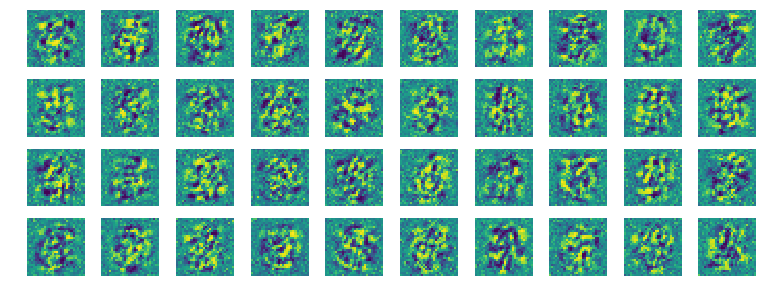

In [0]:
# avgs_z = {}
# for i in range(10):
#   avgs_z[i] = []

import matplotlib.pyplot as plt
f, axarr = plt.subplots(4, 10)
# f.set_figheight(1.4)
# f.set_figwidth(15)
f.set_figheight(5)
f.set_figwidth(15)
f.subplots_adjust(hspace=0.1, wspace=0.3, right = 0.8)


for kk in range(40):
#   plt.figure()
  axarr[kk//10,kk%10].imshow(dd[kk].detach().cpu().view(28,28))
  axarr[kk//10,kk%10].axis('off')
#   avgs_z[target[i]].append()

In [0]:
#   plt.figure()
#   output, code = model(img[i])
#   a = output.reshape([28,28])
#   a = a.cpu().detach()
#   plt.imshow(a.numpy())
  
  
#   plt.figure()
#   c = code.cpu().detach()
#   c = c.reshape([3,3])
#   plt.imshow(c.numpy())
  
  
  
  # vae
  
  i = 2
  plt.figure()
  plt.imshow(img[i].cpu().reshape(28,28))
  
#   recon_batch, mu, logvar
  plt.figure()
  output, code, var = model(img[i])
  a = output.reshape([28,28])
  a = a.cpu().detach()
  plt.imshow(a.numpy())
  
  
  plt.figure()
  c = code.cpu().detach()
  c = c.reshape([4,5])
  plt.imshow(c.numpy())
  
  plt.figure()
  tt = model.decode(c.reshape(1,-1).cuda())
  plt.imshow(tt.cpu().detach().numpy().reshape(28,28))


In [0]:
target

In [0]:
# c.shape
# img[i].shape
dd.shape
c.shape

# tt = model.decode(c.view(1,-1).cuda())
# tt.shape
# c.view(1,-1).shape

c.min()
torch.rand(1, 20).max()
# help(torch.randn)

In [0]:
ttrecon_batch, mu, _ = model(img)  

In [0]:
# del all_preds
# locals()
# mu[2].max()
z = torch.randn(1, 20).cuda()
sample = model.decode(z).cuda()




In [0]:
sample.shape
plt.imshow(sample.detach().cpu().view(28,28))

In [0]:
# # clean one

# batch_size = 1000
# all_size = 10000
# iters = 10

# stats = dict()
# for i in range(10):
#     stats[i] = 0    
    
# avgs = torch.zeros(iters, 10, 28*28)
# avgs_codes = torch.zeros(iters, 10, 20)

# for kk in range(iters):
#   print(kk)
  
#   with torch.no_grad():
#     # vae
#     z_code = torch.randn(all_size, 20).cuda()
#     z = model.decode(z_code).cuda()
    
#     # auto
# #     z_code = torch.rand(all_size, 9).cuda()
# #     z = model.generate(z_code)

#     z = z[:,None,...].view(-1,1, 28,28)
#   #   z = torch.rand(all_size, 1, 28, 28) #.cuda()  
#     z.cuda()

# #     del z_code
  
  
#   all_preds = []
# #   all_confs = []
  
#   for k in range(0,all_size, batch_size):
#       y_pred, _, _, _ = model_n(z[k:k+batch_size].cuda())
#       recon_batch, mu, _ = model(img)        
#       conf, pred = y_pred.data.max(1)
      
      
#       all_preds.append(pred)
# #       all_confs.append(conf)
  
#   preds = torch.cat(all_preds)
# #   confs = torch.cat(all_confs)    
  
# #   weighting
# #   tt = confs[:,None].repeat(1,784)
# #   uu = z.view(-1,28*28)
# #   z = uu* tt.type(torch.FloatTensor)
# #   z = z.view(-1,1,28,28)

#   for i in range(10):
#     stats[i] += torch.sum(preds==i)
#     a = torch.mean(z[preds==i] , dim=0) 
#     avgs[kk, i] = a.reshape(28*28)
#     b = torch.mean(z_code[preds==i] , dim=0) 
#     avgs_codes[kk, i] = b


In [0]:
# clean one

batch_size = 1000
all_size = 1000000
iters = 1

stats = dict()
for i in range(10):
    stats[i] = 0    
    
avgs = torch.zeros(iters, 10, 28*28)
avgs_codes = torch.zeros(iters, 10, latent_d)

for kk in range(iters):
  print(kk)
  
  with torch.no_grad():
#     # vae
#     z_code = torch.randn(all_size, latent_d).cuda()
#     z = model.decode(z_code).cuda()
    
    # auto
    z_code = torch.randn(all_size, 200).cuda()
    z = model.generate(z_code)

    z = z[:,None,...].view(-1,1, 28,28)
  #   z = torch.rand(all_size, 1, 28, 28) #.cuda()  
    z.cuda()

#     del z_code
  
  
  all_preds = []
#   all_confs = []
  
  for k in range(0, all_size, batch_size):
      y_pred, _, _, _ = model_n(z[k:k+batch_size].cuda()) # for prediction
#       recon_batch, mu, _ = model(img)        
      conf, pred = y_pred.data.max(1)
      
      
      all_preds.append(pred)
#       all_confs.append(conf)
  
  preds = torch.cat(all_preds)
#   confs = torch.cat(all_confs)    
  
#   weighting
#   tt = confs[:,None].repeat(1,784)
#   uu = z.view(-1,28*28)
#   z = uu* tt.type(torch.FloatTensor)
#   z = z.view(-1,1,28,28)

  for i in range(10):
    stats[i] += torch.sum(preds==i)
    a = torch.mean(z[preds==i] , dim=0) 
    avgs[kk, i] = a.reshape(28*28)
    b = torch.mean(z_code[preds==i] , dim=0) 
    avgs_codes[kk, i] = b


0


In [0]:
# # y_pred[0]
# z_code = torch.rand(1, 9).cuda()
# z = model.generate(z_code)
# plt.imshow(z.detach().cpu()[0])

In [0]:
# z_code
stats

{0: tensor(12404, device='cuda:0'),
 1: tensor(0, device='cuda:0'),
 2: tensor(0, device='cuda:0'),
 3: tensor(0, device='cuda:0'),
 4: tensor(17552, device='cuda:0'),
 5: tensor(0, device='cuda:0'),
 6: tensor(0, device='cuda:0'),
 7: tensor(44088, device='cuda:0'),
 8: tensor(25432, device='cuda:0'),
 9: tensor(524, device='cuda:0')}

In [0]:
# z[0].shape
z[0].detach().cpu().shape

In [0]:
# code.shape
z_code.shape
# z[:,None,...].view(-1,1, 28,28).shape
len(y_pred)
y_pred[0].shape
z.shape
torch.rand(all_size, 1, 28, 28).dtype
z.dtype
y_pred.data

NameError: ignored

tensor(0.) tensor(1.)
tensor(nan) tensor(nan)
tensor(nan) tensor(nan)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(nan) tensor(nan)
tensor(nan) tensor(nan)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


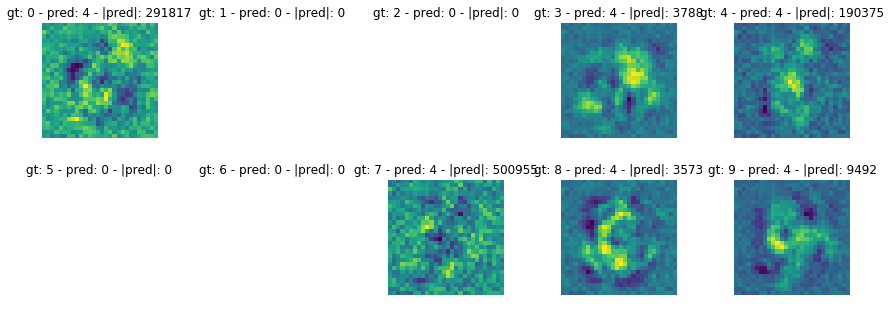

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
# plotting  
save_path = 'drive/My Drive/classification_images/10way-weighted-2Run'
import os


# computing the average mnist images
f, axarr = plt.subplots(2, 5)
# f.set_figheight(1.4)
# f.set_figwidth(15)
f.set_figheight(5)
f.set_figwidth(15)
f.subplots_adjust(hspace=0.36) #, wspace=0.0, right = 0.8)


# mean_imgs = []
# for i in range(10):
#   plt.figure()
#   m = torch.mean(train.data[train.targets == i].type(torch.FloatTensor), dim=0)
#   mean_imgs.append(m)
#   axarr[i//5,i%5].imshow(m) 
  

# avgs[avgs != avgs] = 0 

dd = torch.mean(avgs, dim=0)
# dd = nanmean(avgs.detach(), 0)
 
for kk in range(10):  
  fig = plt.figure()
  a = dd[kk]
  
  a = (a -a.min()) / (a.max() -a.min())
  a = a.view(-1,28)
  
  print(a.min(), a.max())
  b, _, _, _ = model_n(a[None,None,...].cuda())

  #a = torch.nn.functional.log_softmax(a)# torch.nn.functional.softmax(a)
  conf, c = b.data.max(1) #[1]
#   axarr[kk//5,kk%5].set_title(f'gt: {str(kk)}  -  pred: {str(c.cpu().data[0].numpy())} - conf: {str(conf.cpu().data[0].numpy())} -  |pred|: {stats[kk]}')  
  axarr[kk//5,kk%5].set_title(f'gt: {str(kk)} - pred: {str(c.cpu().data[0].numpy())} - |pred|: {stats[kk]}')    
  axarr[kk//5,kk%5].imshow(a.detach()) #, cmap = 'gray')
  axarr[kk//5,kk%5].axis('off')
#   fig.savefig(os.path.join(save_path, str(kk)+'-.png'))

In [0]:
avgs_codes.shape
p = torch.mean(avgs_codes, dim=0)


NameError: ignored

In [0]:
for i in range(10):
  z = model.decode(p[i].cuda()).cuda()  
  plt.figure()
  plt.imshow(z.detach().cpu().view(28,28))

AttributeError: ignored

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


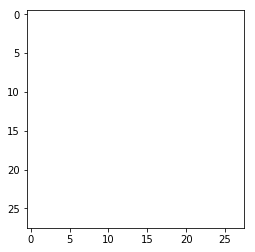

In [0]:
# z.shape
plt.imshow(avgs[0,6].reshape(28,28))
# avgs[0].shape

In [0]:
num_epochs = 20

def resize_tensor(input_tensors, h, w):
  final_output = None
  batch_size, channel, height, width = input_tensors.shape
  input_tensors = torch.squeeze(input_tensors, 1)
  
  for img in input_tensors:
    img_PIL = transforms.ToPILImage()(img)
    img_PIL = torchvision.transforms.Resize([h,w])(img_PIL)
    img_PIL = torchvision.transforms.ToTensor()(img_PIL)
    if final_output is None:
      final_output = img_PIL
    else:
      final_output = torch.cat((final_output, img_PIL), 0)
  final_output = torch.unsqueeze(final_output, 1)
  return final_output

def custom_loss(output1, output2, img): #nn.MSELoss()
#     import pdb; pdb.set_trace()
    h, w = 10, 10 #output2.shape[2:]
    img_lr = img.view(-1, 1, 28, 28)
    img_lr = resize_tensor(img_lr.cpu(), h, w )
#     

    img_lr = img_lr.reshape(-1,h*w)
#     out2 = output2.view(-1, 1, 28, 28)
    return  nn.MSELoss()(output1, img_lr.cuda()) + nn.MSELoss()(output2, img)


class autoencoder_two_branch(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 9))
        
        self.decoder1 = nn.Sequential(
            nn.Linear(9, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 10 * 10), 
            nn.Tanh())

        self.decoder2 = nn.Sequential(
            nn.Linear(9, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())
        
        
    def forward(self, x):
        z = self.encoder(x)
        x1 = self.decoder1(z) # low res
        x2 = self.decoder2(z)         # high res
        return x1, x2, z


model = autoencoder_two_branch().cuda()
# criterion = nn.MSELoss()
# our_criterion =  #nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
#         import pdb; pdb.set_trace()      
        img,_ = data

        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        output1, output2, _ = model(img)   # low res, high res
        loss = custom_loss(output1, output2, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data))
    if epoch % 10 == 0:
        pic_lr = to_img(output1.cpu().data, 10, 10)
        save_image(pic_lr, './mlp_img/image_{}.png'.format(epoch))
        pic_hr = to_img(output2.cpu().data, 28, 28)
        save_image(pic_hr, './mlp_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder_two_branch.pth')
torch.save(model.state_dict(), './drive/My Drive/AutoEncoderProject/sim_autoencoder_two_branch.pth')


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=L size=28x28 at 0x7F74776297F0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 585, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


epoch [1/20], loss:0.0554
epoch [2/20], loss:0.0498
epoch [3/20], loss:0.0451
epoch [4/20], loss:0.0452
epoch [5/20], loss:0.0422
epoch [6/20], loss:0.0366
epoch [7/20], loss:0.0382
epoch [8/20], loss:0.0392
epoch [9/20], loss:0.0404
epoch [10/20], loss:0.0366
epoch [11/20], loss:0.0365
epoch [12/20], loss:0.0358
epoch [13/20], loss:0.0341
epoch [14/20], loss:0.0367
epoch [15/20], loss:0.0364
epoch [16/20], loss:0.0334
epoch [17/20], loss:0.0357
epoch [18/20], loss:0.0343
epoch [19/20], loss:0.0399
epoch [20/20], loss:0.0363


FileNotFoundError: ignored

In [0]:
# img.shape
# output2.shape
    height, width = 10, 10#output2.shape[2:]
    img_lr = img.view(-1, 1, 28, 28)
    img_lr = resize_tensor(img_lr.cpu(), height, width)
#     

    img_lr = img_lr.resize(-1,height*width)
#     out2 = output2.view(-1, 1, 28, 28)
    return  nn.MSELoss()(output1, img_lr) + nn.MSELoss()(output2, img)



In [0]:
# output2.shape
img2 = img.view(-1, 1, 28, 28)
img2.shape

torch.Size([128, 1, 28, 28])

In [0]:
# img[:,::2].shape
img2 = img.reshape(-1, 1, 28, 28)

In [0]:
import math
math.sqrt(392)

19.79898987322333

In [0]:
img2.shape

torch.Size([128, 1, 28, 28])

In [0]:
a = resize_tensor(img2.cpu(), 10, 10)

In [0]:
a.shape

torch.Size([128, 1, 10, 10])

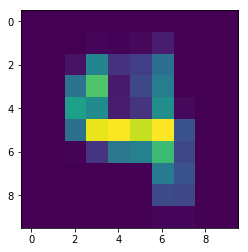

In [0]:
import matplotlib.pyplot as plt
plt.imshow(a[0,0])

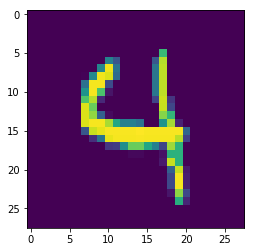

In [0]:
plt.imshow(img2.cpu()[0,0])

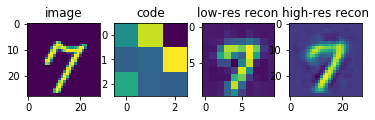

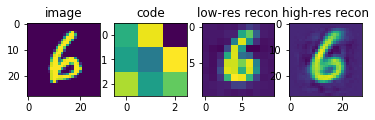

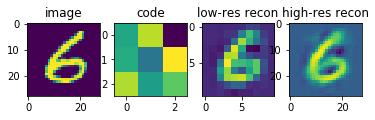

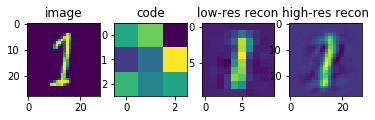

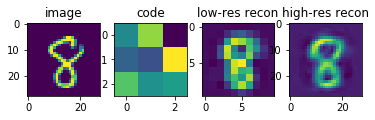

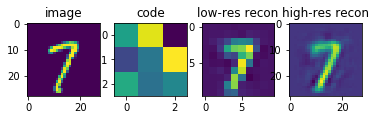

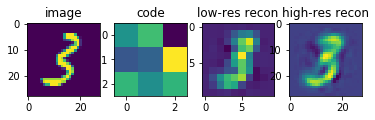

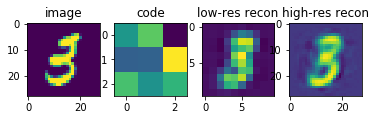

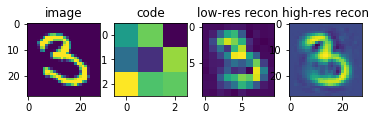

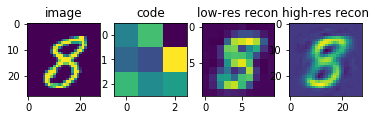

In [0]:
import matplotlib.pyplot as plt
pallete = np.zeros(10*28,28*4)

for i in range(10):
  
  f, axarr = plt.subplots(1, 4)

  c = img[i].cpu().detach()
  c = c.reshape([28,28])  
  axarr[0].imshow(c.numpy())
  axarr[0].set_title('image')  
  
  pallete[:i*28, :28] = c
  
  output_lr, output_hr, code = model(img[i])

  c = code.cpu().detach()
  c = c.reshape([3,3])
  axarr[1].imshow(c.numpy())
  axarr[1].set_title('code')   
  
  pallete[:i*28, :28] = c
  
  a = output_lr.reshape([10,10])
  a = a.cpu().detach()
  axarr[2].imshow(a.numpy())
  axarr[2].set_title('low-res recon')  

  pallete[:i*28, :28] = a
  
  
  a = output_hr.reshape([28,28])
  a = a.cpu().detach()
  axarr[3].imshow(a.numpy())
  axarr[3].set_title('high-res recon')  

  pallete[:i*28, :28] = c 
 
